##### Toy Model of Coaxial Geothermal - Bob.Metcalfe@UTexas.edu - 5/29/20, NEVER FINAL DRAFT

Playing with toy computer models is a great way to innovate. For example, I used toy models to invent Ethernet in 1973. Writing short codes to simulate various novel local-area network archectures led me to discover that there were good and bad system states. Ignoring details, I found convergences and oscillations similar to those later experienced in real life. I explored novel mechanisms for maintaining network stability and efficiency. 

Then we built them. Then we made them industry standards. Then we grew a company to develop, manufacture, market, sell, and support them at scale. Many more sophisicated mathematical and computer models followed my toy first drafts. Ethernet evolved into the Internet's IEEE standard plumbing, with billions of Ethernet ports shipping every year, billions, especially if you let me count Wireless Ethernet AKA Wi-Fi. All starting with toy models.

So here I invite you to play with a toy model of geothermal wells. Professor Eric van Oort and other colleagues are working with much more detailed, much better models and will soon peer-review them. This toy model is merely a blog post. 

Many modellers will tell you they learn more from building models than from numerical results.

My goal participating in http://TexasGEO.org is ... to solve energy once and for all -- cheap, clean, abundant, ubiquitous... We aim to do this with closed-loop baseload geothermal energy. There's plenty of heat in the Earth, billions of years worth. The trick is to harvest the heat safely and econmically, say drilling down ~10km into ~350C granite to bring 150C back to the surface for economic conversion into electricity. 

What you are reading is a Jupyter Python notebook containing an editable and executable toy geothermal well model. Since a major cost of geothermal wells is drilling, I thought I'd start with as little drilling as possible: one drilled hole with two concentric pipes. It's just a coincidence that the first Ethernet in 1973 used coaxial cable. We'll send a working fluid, say water, down the outer pipe into the hole to be heated by surrounding granite. Then we'll bring the hot water back to the surface up the inner pipe, hopefullhy hot enough to be efficiently converted to electricity. We'll see.

In [1]:
# Here we bring in some Python programming resources.
import os
import sys
import math
import copy
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Here are important variables to be global
global NumberOfIterations, NumberOfPipes, LengthOfPipe, PipeString
global DepthOfWell, BottomTemperature, TopTemperature, LoopTime
global History
global JoulesPerIteration, plotJoulesPerIteration
global plotBottomAmbient, plotTopAmbient, plotWellBottom, plotWellTop
global ProbeTracker, ProbePipe, plotProbePipe, ProbeTemp, plotProbeTemp
global plotIterations
global EarthSurfaceTemperature, EarthTemperatureGradient
global HeatExchangeThreshold
global RockDensity, RockSpecificHeat, RockThermalConductivity
global FluidDensity, FluidSpecificHeat, FluidThermalConductivity


In [3]:
# Here is code for commenting orally on simulation progress.
SpeakingOn = True # Turn event announcements on or off
def say(s): 
    if (SpeakingOn): 
        os.system('say ' + s)
        print(s)
say("Toy Geothermal Model")

Toy Geothermal Model


In [4]:
# Here we bring in some physical parameters of planet Earth
# Note we sometimes show the units in brackets, like ""[C/m]"" for degrees Celsius per meter.
EarthSurfaceTemperature = 15.0 # [C] Varies.
EarthTemperatureGradient = 0.025 # [C/m] Varies.

# Ambient temperature in degrees Celsius at depth in meters
def AmbientTemperature(depth): # [C]
    return EarthSurfaceTemperature + (depth * EarthTemperatureGradient)

HeatExchangeThreshold = 150.0 # [C] Only heat at temps above this can be harvested

# Rock is ~granite
RockDensity = GraniteDensity = 2750000.0 # [g/m3]
RockSpecificHeat = GraniteSpecificHeat = 0.790 # [J/gC]
RockThermalConductivity = GraniteThermalConductivity = 2.62 # [W/mC]

# Working fluid is liquid water, ignore for now that water will turn to steam and go supercritical
FluidDensity = WaterDensity = 997000.0 # [g/m3]
FluidSpecificHeat = WaterSpecificHeat = 4.186 # [J/gC]
FluidThermalConductivity = WaterThermalConductivity = 0.6 # [W/mC]

In [5]:
# Here we specify the coaxial pipes with which we are going to drill
# Volume of inner and outer pipes is equal for now
NumberOfPipes = 1000 # [n] 
LengthOfPipe = 10.0 # [m]
DepthOfWell = NumberOfPipes * LengthOfPipe # [m] Assumes we are drilling straight down, vertical well
BottomTemperature = AmbientTemperature(DepthOfWell)
TopTemperature = AmbientTemperature(0)
if (BottomTemperature < HeatExchangeThreshold):
    say("This well will not be deep enough to produce any energy, but drill we must.") 

# AOI: inner pipe has an inner radius, outer pipe has a larger radius to keep up and down same volume.
InnerRadius = 0.5 # [m]
OuterRadius = InnerRadius * math.sqrt(2) # [m] Outer volume is net of inner volume inside it.

pi = math.pi
InnerArea = (2 * pi * InnerRadius) * LengthOfPipe # [m2 = square meters]
OuterArea = (2 * pi * OuterRadius) * LengthOfPipe # [m2]
InnerVolume = (pi * InnerRadius ** 2) * LengthOfPipe # [m3 = cubic meters]
OuterVolume = ((pi * OuterRadius ** 2) * LengthOfPipe) - InnerVolume # [m3] Outer volume is net of inner.
InnerMass = InnerVolume * FluidDensity # [g]
OuterMass = OuterVolume * FluidDensity # [g]

# Check to be sure inner and outer pipe volumes are equal (for now)
if round(InnerVolume,4) != round(OuterVolume,4): print("Inner and outer pipe volumnes are not equal.")

In [6]:
# Let the drilling begin
# Drill straight down by concatenating pipes in a pipe string
PipeString = [] # Starts null, pipes appended at ambient temperature

# i is index of pipe in PipeString, from 0 to NumberOfPipes-1
for i in range(NumberOfPipes):
    ambienttemp = AmbientTemperature(i * LengthOfPipe)
    # fluid goes down outer pipe and up the inner pipe
    pipe = copy.deepcopy({"innertemp": ambienttemp,"outertemp": ambienttemp})
    PipeString.append(pipe) # Drill baby, drill
say("Drill baby drill. " + str(NumberOfPipes) + " pipes to " + str(int(DepthOfWell)) + " meters reaching from " + 
    str(TopTemperature) + " down to " + str(BottomTemperature) + " Celsius.")

Drill baby drill. 1000 pipes to 10000 meters reaching from 15.0 down to 265.0 Celsius.


In [7]:
# ---------- Completion of well at the surface. Bottom pipe is assumed to connect down to up.
IterationTime = 10 # [s] # Each iteration takes time to pump contents of one pipe.
PumpSpeed = InnerVolume/IterationTime # [m3/s]
LoopTime = 2 * (IterationTime * NumberOfPipes)

In [8]:
def Initialize(): # Get ready to run again on exisitng well pipes
    
    global NumberOfPipes, PipeString, LengthOfPipe
    global History
    global plotJoulesPerIteration, JoulesPerIteration
    global plotBottomAmbient
    global plotTopAmbient
    global plotWellBottom
    global plotWellTop
    global ProbeTracker
    global ProbePipe
    global plotProbePipe
    global ProbeTemp
    global plotProbeTemp
    global plotIterations, iteration

    History = [] # This could be huge, collects all pipes at all iterations.
    JoulesPerIteration = 0
    plotJoulesPerIteration = []
    plotBottomAmbient = []
    plotTopAmbient = []
    plotWellBottom = []
    plotWellTop = []
    ProbeTracker = ((2 * NumberOfPipes) - 1) # To start increment at outer zero (0)
    ProbePipe = 0
    plotProbePipe = []
    ProbeTemp = 0
    plotProbeTemp = []
    plotIterations = []

    # i is index of pipe in PipeString, from 0 to NumberOfPipes-1, init with ambient at depth
    for i in range(NumberOfPipes):
        ambienttemp = AmbientTemperature(i * LengthOfPipe)
        # fluid goes down outer pipe and up the inner pipe
        PipeString[i] = copy.deepcopy({"innertemp": ambienttemp,"outertemp": ambienttemp})
        

In [9]:
# This AOI may look like thermodynamics, but it is not.

def AOI():
    
    global PipeString, LengthOfPipe
    
    for j in range(len(PipeString)): # once for each pipe, from 0 to len(PipeString)-1
        
        pipe = PipeString[j] # one pipe at a time
        
        Atemp = AmbientTemperature(j * LengthOfPipe)
        OtempStart = pipe["outertemp"]
        ItempStart = pipe["innertemp"]
        
        OtempEnd = (Atemp + OtempStart + ItempStart) / 3.0
        ItempEnd = (OtempStart + ItempStart) / 2.0
        
        pipe["outertemp"] = OtempEnd
        pipe["innertemp"] = ItempEnd
        
        PipeString[j] = copy.deepcopy(pipe)

In [10]:
# pump fluid around PipeString, down outer, up inner chamber
# AOL = Ambient, Outer (down), Inner (up)

def Flow(): 
    
    global History
    global PipeString, NumberOfPipes, LengthOfPipe
    global JoulesPerIteration, plotJoulesPerIteration, TopTemp, UseableTemp, HeatExchangeThreshold
    global OuterMass, FluidSpecificheat
    global ProbeTracker, plotProbePipe, ProbePipe, ProbeTemp
    global plotBottomAmbient, plotTopAmbient
    global plotWellBottom, plotWellTop
    global plotProbeTemp, ProbeTemp
    global plotIterations, iteration
    global BottomTemperature, TopTemperature
    global FluidSpecificHeat

    NOP = len(PipeString) # Number Of Pipes
    if (NOP != NumberOfPipes):
        print("Number of pipes mismatch",NumberOfPipes,NOP)
        sys.exit(0)
        
    # Collect history for plotting at the end
    # History.append(copy.deepcopy(PipeString)) # This is big: iterations X pipes X temperatures
    
    plotJoulesPerIteration.append(JoulesPerIteration)
    plotBottomAmbient.append(AmbientTemperature(len(PipeString) * LengthOfPipe))
    plotTopAmbient.append(AmbientTemperature(0))
    plotWellBottom.append(PipeString[-1]["outertemp"]) # Temperature of working fluid at bottom of well
    plotWellTop.append(PipeString[0]["innertemp"]) # Temperature of working fluid at top of the well
    plotProbePipe.append(ProbePipe)
    plotProbeTemp.append(ProbeTemp)
    plotIterations.append(iteration)


    # Be sure circulation of working fluid does not lose any frluid, add all up
    checksum = 0
    for p in PipeString:
        checksum += (round(p["outertemp"],3) + round(p["innertemp"],3))
        
    ################ Start moving fluid
    
    saved0i = PipeString[0]["innertemp"] # Temp hold on temperature about to be overwritten, 0th inner, top inner

    # Move fluid up inner pipe
    for n in range(NOP-1):
        PipeString[n]["innertemp"] = PipeString[n+1]["innertemp"] # fluid moving up

    # Turn around at bottom of well, from down outer to up inner
    PipeString[NOP-1]["innertemp"] = PipeString[NOP-1]["outertemp"]

    # Move fluid down outer pipe
    for n in range(NOP-1,0,-1):
        PipeString[n]["outertemp"] = PipeString[n-1]["outertemp"]

    PipeString[0]["outertemp"] = saved0i
    
    #Check that working fluid is conserved
    check = 0
    for p in PipeString:
        check += (round(p["outertemp"],3) + round(p["innertemp"],3))
    if (round(check,3) != round(checksum,3)):
        print("Flow pumping is broken.")
        sys.exit(0)

    # Move Probe
    
    ProbeTracker = ProbeTracker + 1 # Advance probe outer: 0 -> NOP-1; inner: NOP -> 2NOP-1
    
    if (ProbeTracker > ((2 * NumberOfPipes) - 1)): 
        ProbeTracker = 0 # Probe varies from 0 to 2*NOP-1
        
    if (ProbeTracker <= (NumberOfPipes - 1)): # Is probe in downward pipe?
        ProbePipe = ProbeTracker # Downward
        ProbeTemp = PipeString[ProbePipe]["outertemp"]
    elif ((NumberOfPipes - 1) < ProbeTracker < (2 * NumberOfPipes)):
        ProbePipe = ((2 * NumberOfPipes) - 1) - ProbeTracker # Upward
        ProbeTemp = PipeString[ProbePipe]["innertemp"]
    else:
        print("ProbeTracker out of range.")
        sys.exit(0)
        
    # Adjust probe for dispay among temperatures
    ProbePipe = ((ProbePipe / (NumberOfPipes - 1)) * 
                 (BottomTemperature - TopTemperature)) + TopTemperature
        
    ################# End moving fluid - Harvest C appearing at top
    
    TopTemp = PipeString[0]["outertemp"]
    if (TopTemp > HeatExchangeThreshold):
        UseableTemp = TopTemp - HeatExchangeThreshold
        PipeString[0]["outertemp"] = HeatExchangeThreshold
        JoulesPerIteration = OuterMass * FluidSpecificHeat * UseableTemp


In [11]:
def IterationPlot(suptitletext=''): 
    
    global plotIterations
    
    global plotJoulesPerIteration
    global plotBottomAmbient
    global plotTopAmbient
    global plotWellBottom
    global plotWellTop
    global plotProbePipe
    global plotProbeTemp
    
    global BottomTemperature, TopTemperature
    
    t = 0.0
    for j in range(len(plotJoulesPerIteration)):
        t += plotJoulesPerIteration[j]
    print("Total 'joules' produced are",f"{round(t):,}")
    
    f = plt.figure(figsize=(20,10))
    plt.plot(plotIterations, plotBottomAmbient, color='red', linestyle='dashed', linewidth = 5)
    plt.plot(plotIterations, plotTopAmbient, color='green', linestyle='dashed', linewidth = 5)
    plt.plot(plotIterations, plotWellBottom, color='blue', linestyle='dashed', linewidth = 7)
    plt.plot(plotIterations, plotWellTop, color='black', linestyle='dashed', linewidth = 3)
    plt.plot(plotIterations, plotProbePipe, color='orange', linewidth = 1)
    plt.plot(plotIterations, plotProbeTemp, color='black', linewidth = 1)

    plt.xlabel('Iterations')
    plt.ylabel('Bot Amb Red, Top Amb Green, Well Bot Blue, Well Top Black, Probe Yellow/Orange')
    plt.title("Metcalfe's Toy Coax Geothermal Model")
    plt.suptitle(suptitletext)
    plt.grid(True)
    plt.ylim(BottomTemperature,TopTemperature)
    plt.show()
    

Crude Temperature Averaging

Starting Crude Temperature Averaging over 1000 iterations.
Iteration 1 thousand
Total 'joules' produced are 0


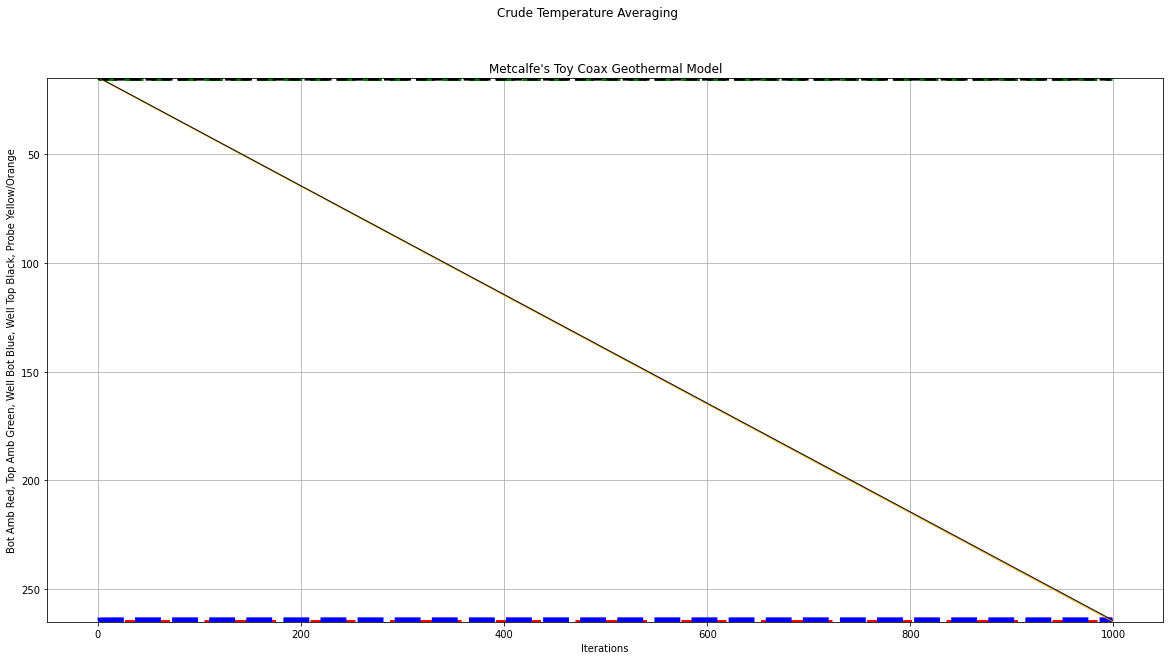

Completed Crude Temperature Averaging


In [12]:
titlestring = "Crude Temperature Averaging"

Initialize()

NumberOfIterations = 1000 # int(NumberOfPipes * 0.5)

say("Starting " + titlestring + " over " + str(NumberOfIterations) + " iterations.") 

if (NumberOfIterations > 0):
    for iteration in range(NumberOfIterations): # iteration on thermo update 
        AOI() # Update inner and outer temps from AOI
        Flow() # Move working fluid one pipe along, up, down, and around
        if ((iteration%1000) == 999):
            thousands = str((iteration+1)//1000)
            say("Iteration " + thousands + " thousand")  
    IterationPlot(titlestring) 
    say("Completed " + titlestring)
else:
    say("Skipped.")


In [13]:
# This AOI may look like thermodynamics, but it is not.

def AOI2():
    
    global PipeString, LengthOfPipe
    
    for j in range(len(PipeString)): # once for each pipe, from 0 to len(PipeString)-1
        
        # What about PumpTime, Mass
        
        pipe = PipeString[j] # one pipe at a time
                
        Atemp = AmbientTemperature(j * LengthOfPipe)
        OtempStart = pipe["outertemp"]
        ItempStart = pipe["innertemp"]
        
        OtempEnd = (Atemp + 10*OtempStart) / 11.0
        ItempEnd = (OtempStart + 50*ItempStart) / 51.0
        
        # DeltaAO = Atemp - OtempStart
        # DeltaOI = OtempStart - ItempStart
        
        # OtempEnd = OtempStart + (10.0 * DeltaAO * FluidThermalConductivity * OuterArea * IterationTime) / OuterMass
        # ItempEnd = ItempStart + (2.0 * DeltaOI * FluidThermalConductivity * InnerArea * IterationTime) / InnerMass

        pipe["outertemp"] = OtempEnd
        pipe["innertemp"] = ItempEnd

        PipeString[j] = copy.deepcopy(pipe)
        
        # print("AOI2",j,Atemp,OtempStart,OtempEnd,ItempStart,ItempEnd,pipe)
        

Starting Simple Heat Flow over 100 iterations.
Total 'joules' produced are 0


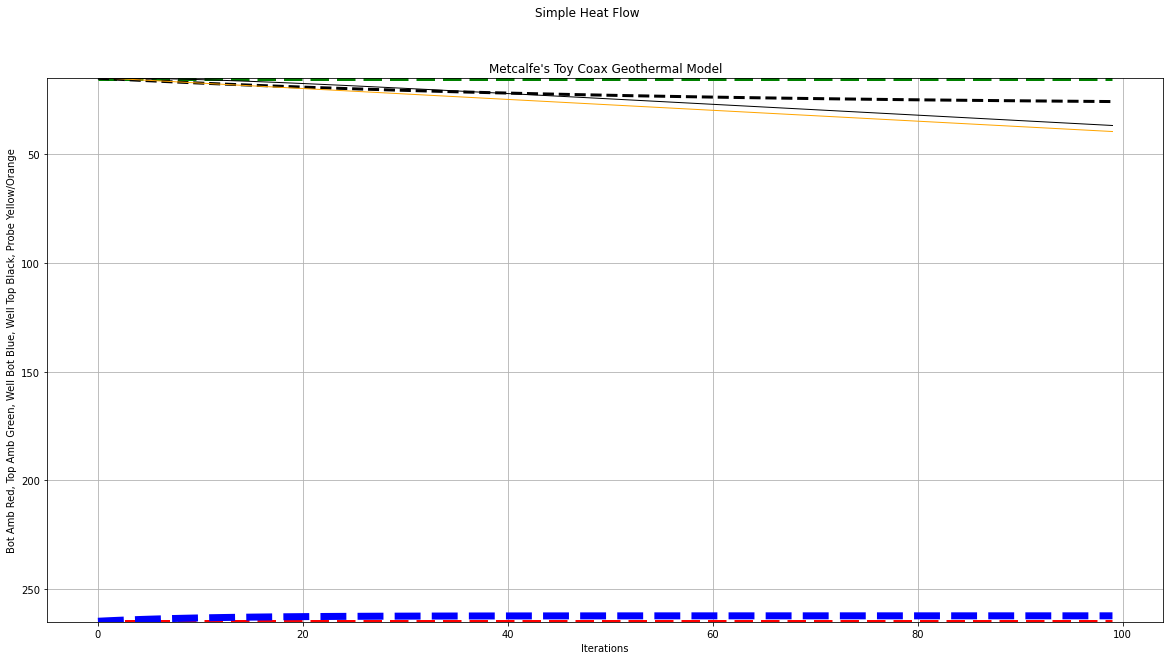

Completed Simple Heat Flow


In [14]:
titlestring = "Simple Heat Flow"

Initialize()

NumberOfIterations = 100

say("Starting " + titlestring + " over " + str(NumberOfIterations) + " iterations.") 

if (NumberOfIterations > 0):
    for iteration in range(NumberOfIterations): # iteration on thermo update
        AOI2() # Update inner and outer temps from AOI
        Flow() # Move working fluid one pipe along, up, down, and around 
        if ((iteration%1000) == 999):
            thousands = str((iteration+1)//1000)
            say("Iteration " + thousands + " thousand")
    IterationPlot(titlestring)
    say("Completed " + titlestring)
else:
    say("Skipped.")

Insulation of pipestring nearer the surface

In [15]:
def AOIINS():
    
    global PipeString, LengthOfPipe, Transition
    
    for j in range(len(PipeString)): # once for each pipe, from 0 to len(PipeString)-1
                
        pipe = PipeString[j] # one pipe at a time
        
        Atemp = AmbientTemperature(j * LengthOfPipe)
        OtempStart = pipe["outertemp"]
        ItempStart = pipe["innertemp"]
        
        OtempEnd = (Atemp + OtempStart + ItempStart) / 3.0
        ItempEnd = (OtempStart + ItempStart) / 2.0
        
        pipe["outertemp"] = OtempEnd
        
        if (j > Transition): # Leave inner temp unchanged below insulation transition 
            pipe["innertemp"] = ItempEnd
            
        PipeString[j] = copy.deepcopy(pipe)


Starting Top Segment Insulation with iterations 100
Total 'joules' produced are 0


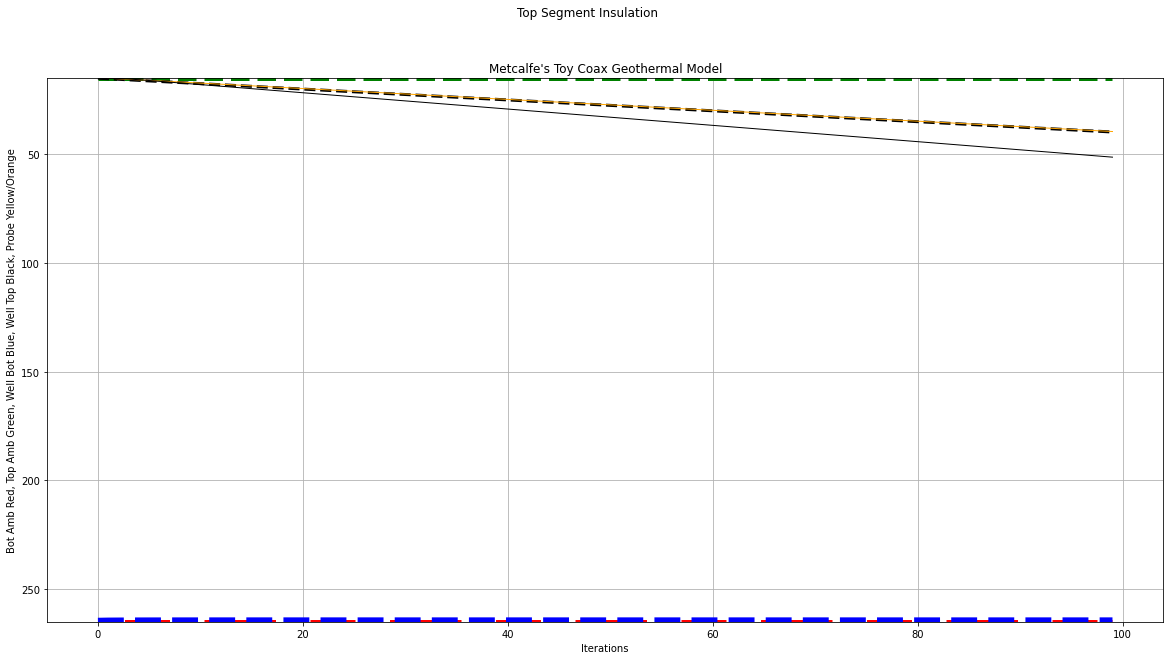

Completed Top Segment Insulation


In [16]:
titlestring = "Top Segment Insulation"

Transition = NumberOfPipes / 2.0

Initialize()

NumberOfIterations = 100

say("Starting " + titlestring + " with iterations " + str(NumberOfIterations))

    
for iteration in range(NumberOfIterations): # iteration on thermo update
    
    AOIINS() # Update inner and outer temps from AOI
    
    Flow() # Move working fluid one pipe along, up, down, and around 
    
    if ((iteration%1000) == 999):
        thousands = str((iteration+1)//1000)
        say("Iteration " + thousands + " thousand")
        
IterationPlot(titlestring)
        
say("Completed " + titlestring)

Twist Pipe Insertion

In [17]:
plotWellTop

[15.0,
 15.25,
 15.5,
 15.75,
 16.0,
 16.25,
 16.5,
 16.75,
 17.0,
 17.25,
 17.5,
 17.75,
 18.0,
 18.25,
 18.5,
 18.75,
 19.0,
 19.25,
 19.5,
 19.75,
 20.0,
 20.25,
 20.5,
 20.75,
 21.0,
 21.25,
 21.5,
 21.75,
 22.0,
 22.25,
 22.5,
 22.75,
 23.0,
 23.25,
 23.5,
 23.75,
 24.0,
 24.25,
 24.5,
 24.75,
 25.0,
 25.25,
 25.5,
 25.75,
 26.0,
 26.25,
 26.5,
 26.75,
 27.0,
 27.25,
 27.5,
 27.75,
 28.0,
 28.25,
 28.5,
 28.75,
 29.0,
 29.25,
 29.5,
 29.75,
 30.0,
 30.25,
 30.5,
 30.75,
 31.0,
 31.25,
 31.5,
 31.75,
 32.0,
 32.25,
 32.5,
 32.75,
 33.0,
 33.25,
 33.5,
 33.75,
 34.0,
 34.25,
 34.5,
 34.75,
 35.0,
 35.25,
 35.5,
 35.75,
 36.0,
 36.25,
 36.5,
 36.75,
 37.0,
 37.25,
 37.5,
 37.75,
 38.0,
 38.25,
 38.5,
 38.75,
 39.0,
 39.25,
 39.5,
 39.75]

In [18]:
def AOI4():
    
    global PipeString, LengthOfPipe, Transition
    
    for j in range(len(PipeString)): # once for each pipe, from 0 to len(PipeString)-1
        
        if (j < Transition): continue # Higher pipes are insulated and gain/lose NO temperature
        
        pipe = PipeString[j] # one pipe at a time
        
        Atemp = AmbientTemperature(j * LengthOfPipe)
        OtempStart = pipe["outertemp"]
        ItempStart = pipe["innertemp"]
        
        DeltaAO = Atemp - OtempStart
        DeltaOI = OtempStart - ItempStart
        
        OtempEnd = OtempStart + (5.0 * DeltaAO * FluidThermalConductivity * OuterArea * IterationTime) / OuterMass
        ItempEnd = ItempStart + (5.0 * DeltaOI * FluidThermalConductivity * InnerArea * IterationTime) / InnerMass

        if (j == Transition): # Here the inner and outer pipes get switched
            pipe["outertemp"] = ItempEnd
            pipe["innertemp"] = OtempEnd
        else:
            pipe["outertemp"] = OtempEnd
            pipe["innertemp"] = ItempEnd
        
        PipeString[j] = copy.deepcopy(pipe)

In [19]:
titlestring = "Twist Pipe Insertion"
say("Starting " + titlestring)

Transition = NumberOfPipes / 2.0

Initialize()

NumberOfIterations = 100

    
for iteration in range(NumberOfIterations): # iteration on thermo update
    
    AOI3() # Update inner and outer temps from AOI, with twist at transition
    
    Flow() # Move working fluid one pipe along, up, down, and around 
    
    if ((iteration%1000) == 999):
        thousands = str((iteration+1)//1000)
        say("Iteration " + thousands + " thousand")
    
IterationPlot(titlestring)

say("Completed " + titlestring)

Starting Twist Pipe Insertion


NameError: name 'AOI3' is not defined

Horizontal Leg

Small Faster Heat Return

In [ ]:
say("Toy Geothermal Model Completed. Have a nice day.")


MAINTENANCE AND DEBUGGING

In [ ]:
def PPS():
    print("\n---- aaaaaa oooooo iiiiii")
    for k in range(NumberOfPipes):
        # if (math.remainder(k,100) != 0) and (k != NumberOfPipes-1):
        #    continue
        ps0 = "{:4d}".format(k)
        ps1 = "{:6.2f}".format(AmbientTemperature(k*LengthOfPipe))
        ps2 = "{:6.2f}".format(PipeString[k]["outertemp"])
        ps3 = "{:6.2f}".format(PipeString[k]["innertemp"])
        print(ps0,ps1,ps2,ps3)


In [ ]:
PPS()